In [0]:
import numpy as np

import copy
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, utils
from IPython.display import display
from PIL import Image
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH_TO_DATA = '/content/drive/My Drive/MATT/MLEARN/MLEARN.zip (Unzipped Files)/MLEARN/00Data'

In [0]:
# Random Seed
torch.manual_seed(1)
np.random.seed(1)

# Select the available device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

In [0]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20191209.csv')
data = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')

In [14]:
data.head()

,Unnamed: 0,B365H,B365D,B365A,FTR,Date,HomeTeam,AwayTeam,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMax,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0,2.2,3.2,3.50,D,26/08/2016,Betis,La Coruna,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,71.400000,75.0,79.0,74.818182,76.0,81.0,73.678571,75.5,81.0,73.666667,70.0,78.181818,78.0,60.0,1.000000,2.0,2.0,2,1.0,1.0,1,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0
1,1,2.3,3.1,3.40,D,26/08/2016,Espanol,Malaga,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,73.000000,75.0,79.0,75.300000,77.0,82.0,74.250000,76.5,82.0,75.000000,79.0,78.454545,78.0,64.0,0.333333,1.0,1.0,1,1.0,1.0,1,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0
2,2,2.7,3.2,2.75,H,27/08/2016,Eibar,Valencia,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,70.500000,72.5,79.0,73.900000,77.0,79.0,71.870968,75.0,75.0,68.500000,69.5,77.545455,78.0,60.0,0.000000,2.0,2.0,2,4.0,4.0,4,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0
3,3,8.5,3.6,1.53,D,27/08/2016,Leganes,Ath Madrid,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,69.500000,71.0,77.0,73.500000,74.0,77.0,71.939394,73.0,76.0,71.750000,73.0,76.181818,76.0,61.0,0.333333,1.0,1.0,1,1.0,1.0,1,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,

In [0]:
data = data.drop(columns=['Unnamed: 0','HomeTeam','AwayTeam'])

In [0]:
data['B365H'] = 1/data['B365H']
data['B365D'] = 1/data['B365D']
data['B365A'] = 1/data['B365A']
data['Sum'] = data['B365H'] + data['B365D'] + data['B365A'] 
data['B365H'] = data['B365H']/data['Sum']
data['B365D'] = data['B365D']/data['Sum']
data['B365A'] = data['B365A']/data['Sum']

In [17]:
data.head()

,B365H,B365D,B365A,FTR,Date,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMax,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin,Sum
0,0.431766,0.296839,0.271396,D,26/08/2016,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,71.400000,75.0,79.0,74.818182,76.0,81.0,73.678571,75.5,81.0,73.666667,70.0,78.181818,78.0,60.0,1.000000,2.0,2.0,2,1.0,1.0,1,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0,1.052760
1,0.413495,0.306787,0.279718,D,26/08/2016,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,73.000000,75.0,79.0,75.300000,77.0,82.0,74.250000,76.5,82.0,75.000000,79.0,78.454545,78.0,64.0,0.333333,1.0,1.0,1,1.0,1.0,1,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0,1.051481
2,0.353911,0.298613,0.347476,H,27/08/2016,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,70.500000,72.5,79.0,73.900000,77.0,79.0,71.870968,75.0,75.0,68.500000,69.5,77.545455,78.0,60.0,0.000000,2.0,2.0,2,4.0,4.0,4,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0,1.046507
3,0.112150,0.264798,0.623053,D,27/08/2016,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,69.500000,71.0,77.0,73.500000,74.0,77.0,71.939394,73.0,76.0,71.750000,73.0,76.181818,76.0,61.0,0.333333,1.0,1.0,1,1.0,1.0,1,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,82.0,88.0,75.66

In [0]:
del data['Sum']

In [0]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [0]:
class DatasetDF(Dataset):
    
    def __init__(self, data, ftrs, dates):
        self.data = data
        self.transform = torch.FloatTensor
        self.ftrs = ftrs
        self.dates = dates
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        sample = self.data.iloc[index, 4:].values
        label = self.data.iloc[index, :3]
        sample = np.array(list(sample), dtype=np.float)
        label = np.array(list(label), dtype=np.float)
        ftr = self.ftrs[index]
        date = self.dates[index]
        
        return self.transform(sample), self.transform(label), ftr, date

In [0]:
hparams1 = {
    'num_epochs': 15,
    'batch_size': 5,
    'test_batch_size': 5,
    'criterion': F.mse_loss,
    'learning_rate': 1e-3,
    'log_interval': 40,
}

In [0]:
dataset = DatasetDF(data.drop(columns='FTR'), data['FTR'], data['Date'])

In [0]:
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.15 * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams1['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams1['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

In [25]:
dataset.__getitem__(0)

(tensor([ 0.0000,  2.0000,  2.0000,  2.0000,  6.0000,  6.0000,  6.0000, 10.0000,
          6.0000,  5.0000, 11.0000,  7.0000,  8.0000, 15.0000,  6.0000,  6.0000,
         12.0000, 45.0000,  0.8947,  1.0000,  2.0000,  1.0000,  0.8947,  1.0000,
          3.0000,  1.0000, 26.1429, 25.0000, 78.0000, 73.5556, 73.0000, 81.0000,
         71.4000, 75.0000, 79.0000, 74.8182, 76.0000, 81.0000, 73.6786, 75.5000,
         81.0000, 73.6667, 70.0000, 78.1818, 78.0000, 60.0000,  1.0000,  2.0000,
          2.0000,  2.0000,  1.0000,  1.0000,  1.0000, 15.0000,  4.0000,  4.0000,
          8.0000,  7.0000,  5.0000, 12.0000,  8.0000, 10.0000, 18.0000, 42.0000,
          1.3158,  1.0000,  3.0000,  2.0000,  1.0526,  1.0000,  3.0000,  1.0000,
         25.6667, 25.0000, 79.0000, 74.6250, 75.0000, 79.0000, 68.5000, 67.0000,
         79.0000, 72.0625, 74.0000, 79.0000, 72.1515, 75.0000, 75.0000, 73.3333,
         75.0000, 77.2727, 77.0000, 61.0000]),
 tensor([0.4318, 0.2968, 0.2714]),
 'D',
 '26/08/2016')

In [0]:
def train_epoch(model, hparams, loader, optimizer, device, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target, _, _) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        criterion = hparams['criterion']
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % hparams['log_interval'] == 0:
            dataset_len = len(loader) * hparams['batch_size']
            processed_data_len = batch_idx * hparams['batch_size']
            processed_data_len_str = format(processed_data_len, '0'+str(len(str(dataset_len))))
            processed_ratio = round((100. * batch_idx / len(loader)),0)
            loss_str = str(round(loss.item(),6))
            print(f"Train Epoch: {epoch} [{processed_data_len_str}/{dataset_len} "+\
                  f"({processed_ratio}%)]\tLoss: {loss_str}")
    return losses

In [0]:
def validate_epoch(model, hparams, loader, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target, _, _ in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            criterion = hparams['criterion']
            loss = criterion(output, target)
            losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    validation_loss_str = str(round(avg_loss,6))
    print(f"\nValidation:\t\t\t\tLoss: {validation_loss_str} (avg.)\n\n")
    
    return avg_loss

In [0]:
def train(model, hparams, train_loader, valid_loader, optimizer, device):
    train_losses = []
    valid_losses = []
    valid_x = []
    for epoch in range(1, hparams['num_epochs'] + 1):
        epoch_train_losses = train_epoch(model, hparams, train_loader,
                                         optimizer, device, epoch)
        train_losses.extend(epoch_train_losses)
        epoch_valid_loss = validate_epoch(model, hparams, valid_loader, device)
        valid_losses.append(epoch_valid_loss)
        valid_x.append(len(train_losses) - 1)

    train_x = range(len(train_losses))

    return (train_x, train_losses), (valid_x, valid_losses)

In [0]:
def compute_avg_mse(model, loader):
    avg_mse = []
    for inputs, _, _, _ in iter(loader):
        outputs = model(inputs.to(device))
        outputs = outputs.detach().cpu().numpy()
        for input_, output in zip(inputs, outputs):
            mse = (np.square(input_.detach().cpu().numpy() - output)).mean(axis=None)
            avg_mse.append(mse)
    avg_mse = sum(avg_mse) / len(avg_mse)
    return avg_mse

In [30]:
img, lab, ftr, date = dataset.__getitem__(0)

print(img.shape)
print(type(img))
print(ftr)
print(date)

torch.Size([92])
<class 'torch.Tensor'>
D
26/08/2016


In [0]:
class MyNet(nn.Module):
  
  def __init__(self):
    super().__init__() 
    self.fc1 = nn.Linear(92, 40)
    self.act1 = nn.ReLU()
    self.fc2 = nn.Linear(40, 10)
    self.act2 = nn.ReLU()
    self.fc3 = nn.Linear(10, 3)
    self.act3 = nn.Sigmoid()
    
  def forward(self, x):
    h1 = self.act1(self.fc1(x))
    h2 = self.act2(self.fc2(h1))
    y = self.act3(self.fc3(h2))
    return y

network = MyNet()

In [0]:
class MyNets(nn.Module):
  
  def __init__(self,layers):
    super().__init__()
    self.act = nn.ModuleList([])
    self.fc = nn.ModuleList([])
    for layer in range(len(layers)-1):
      self.fc.append(nn.Linear(layers[layer], layers[layer+1]))
      self.act.append(nn.ReLU())
    self.act[layer] = nn.Sigmoid()
    #logsoftmax
    #Dropout
    
  def forward(self, x):
    for activ, fc in zip(self.act, self.fc):
      x = activ(fc(x))
    return x

In [0]:
dic_nets = {
    0:[92,40,10,3],
    1:[92,70,40,12,3],
    2:[92,61,30,15,8,3],
    3:[92,50,3],
    4:[92,120,120,20,3]
}

In [0]:
models = dict.fromkeys(dic_nets.keys(), None)
tr_losses = dict.fromkeys(dic_nets.keys(), None)
val_losses = dict.fromkeys(dic_nets.keys(), None)

In [35]:
for i in range(len(dic_nets.keys())):
  print(i)

0
1
2
3
4


In [36]:
for i in dic_nets.keys():
  models[i] = MyNets(dic_nets[i])
  optimizer = optim.Adam(models[i].parameters(),
                        lr=hparams1['learning_rate'])
  tr_losses[i], val_losses[i] = train(models[i], hparams1, train_loader, valid_loader, optimizer, device)

Train Epoch: 1 [0000/1020 (0.0%)]	Loss: 0.099446
Train Epoch: 1 [0200/1020 (20.0%)]	Loss: 0.010315
Train Epoch: 1 [0400/1020 (39.0%)]	Loss: 0.039308
Train Epoch: 1 [0600/1020 (59.0%)]	Loss: 0.025186
Train Epoch: 1 [0800/1020 (78.0%)]	Loss: 0.01024
Train Epoch: 1 [1000/1020 (98.0%)]	Loss: 0.006856

Validation:				Loss: 0.00723 (avg.)


Train Epoch: 2 [0000/1020 (0.0%)]	Loss: 0.005246
Train Epoch: 2 [0200/1020 (20.0%)]	Loss: 0.009498
Train Epoch: 2 [0400/1020 (39.0%)]	Loss: 0.007724
Train Epoch: 2 [0600/1020 (59.0%)]	Loss: 0.009072
Train Epoch: 2 [0800/1020 (78.0%)]	Loss: 0.024112
Train Epoch: 2 [1000/1020 (98.0%)]	Loss: 0.00607

Validation:				Loss: 0.007172 (avg.)


Train Epoch: 3 [0000/1020 (0.0%)]	Loss: 0.015881
Train Epoch: 3 [0200/1020 (20.0%)]	Loss: 0.009144
Train Epoch: 3 [0400/1020 (39.0%)]	Loss: 0.005904
Train Epoch: 3 [0600/1020 (59.0%)]	Loss: 0.003176
Train Epoch: 3 [0800/1020 (78.0%)]	Loss: 0.004151
Train Epoch: 3 [1000/1020 (98.0%)]	Loss: 0.006981

Validation:				Loss: 0.00

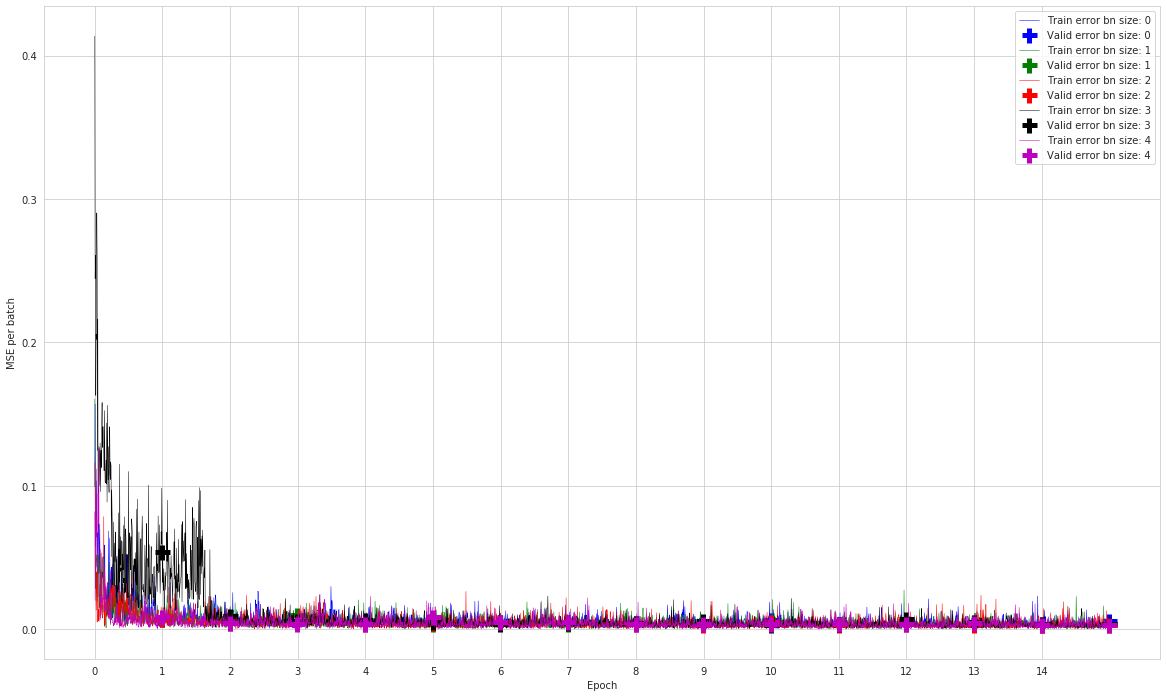

In [37]:
plt.figure(figsize=(20,12))
colors = "bgrkmycw"

for i, bn_size in enumerate(dic_nets.keys()):
    plt.plot(tr_losses[bn_size][0], tr_losses[bn_size][1], '-', color=colors[i],
             lw=0.5, label=f'Train error bn size: {bn_size}')
    plt.plot(val_losses[bn_size][0], val_losses[bn_size][1], '+', color=colors[i],
             ms=15.0, mew=5.0, label=f'Valid error bn size: {bn_size}')

plt.xticks(np.arange(0, max(tr_losses[bn_size][0]),
                     step=max(tr_losses[bn_size][0])/hparams1['num_epochs']), 
                     [i for i in range(hparams1['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('MSE per batch')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
for i in range(len(dic_nets.keys())):
  print(math.sqrt(val_losses[i][1][len(val_losses[i][1])-1])/3)
#RMSE
#posar dependencia del resultat al caclul de lerror

0.025036291955090398
0.019952556015498994
0.018566092295903926
0.019691024003462
0.01870105268617679


In [0]:
def compute_avg_mse_split(model, loader):
    avg_mseH = []
    avg_mseD = []
    avg_mseA = []
    for inputs, targets, _, _ in iter(loader):
        outputs = model(inputs.to(device))
        targets = targets.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        for i in range(targets.shape[0]):
          avg_mseH.append((targets[i,0]-outputs[i,0])**2)
          avg_mseD.append((targets[i,1]-outputs[i,1])**2)
          avg_mseA.append((targets[i,2]-outputs[i,2])**2)
    avg_mseH = sum(avg_mseH) / len(avg_mseH)
    avg_mseD = sum(avg_mseD) / len(avg_mseD)
    avg_mseA = sum(avg_mseA) / len(avg_mseA)
    return avg_mseH, avg_mseD, avg_mseA

In [40]:
avg_mseH, avg_mseD, avg_mseA = compute_avg_mse_split(models[2],valid_loader)
print(math.sqrt(avg_mseH))
print(math.sqrt(avg_mseD))
print(math.sqrt(avg_mseA))

0.06738552712005005
0.029403638009146492
0.06235073580052807


In [41]:
print((avg_mseH))
print((avg_mseD))
print((avg_mseA))

0.004540809265247002
0.0008645739281729244
0.0038876142548672533


In [0]:
def validate_epoch2(model, hparams, loader, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target, _, _ in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            criterion = hparams['criterion']
            loss = criterion(output, target)
            losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    validation_loss_str = str(round(avg_loss,6))
    print(f"\nValidation:\t\t\t\tLoss: {validation_loss_str} (avg.)\n\n")
    
    return avg_loss

In [0]:
def getMin(a, liston=-0.05):
  aux = min(a)
  if (aux > liston):
    return '_'
  for lletra in ['H','D','A']:
    if aux == a[lletra]:
      return lletra

In [0]:
def getWinning(d):
  if d['Win'] == '_':
    return 0
  elif d['Win'] == d['FTR']:
    return d['B365'+d['Win']] - 1
  else:
    return -1

In [45]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')
val_iter = iter(valid_loader)
tot = 0
llista_vals = []
apuestas = 0
aciertos = 0
for i in range(10):
  inputs, targets, ftr, date = val_iter.next()
  outputs = models[2](inputs.to(device))
  outputs = outputs.detach().cpu().numpy()
  targets = targets.detach().cpu().numpy()

  data_res = data.copy()
  res = pd.concat([pd.DataFrame(targets,columns=['B365H','B365D','B365A']), pd.DataFrame(outputs,columns=['B365H_Pred','B365D_Pred','B365A_Pred'])],axis=1)
  res['FTR'] = ftr
  res['Date'] = date
  N = 10000
  #thank you koalo for comment
  res.B365H = np.round(res.B365H*N).astype(int) 
  data_res.B365H = np.round(data_res.B365H*N).astype(int) 
  res.B365D = np.round(res.B365D*N).astype(int) 
  data_res.B365D = np.round(data_res.B365D*N).astype(int) 
  res.B365A = np.round(res.B365A*N).astype(int) 
  data_res.B365A = np.round(data_res.B365A*N).astype(int) 
  res = pd.merge(res,data_res,how='left', on=['B365H','B365D','B365A','FTR', 'Date'],)
  res.B365H = res.B365H/N
  res.B365D = res.B365D/N
  res.B365A = res.B365A/N

  res['H'] = res['B365H'] - res['B365H_Pred']
  res['D'] = res['B365D'] - res['B365D_Pred']
  res['A'] = res['B365A'] - res['B365A_Pred']
  a = res[['H','D','A']].copy()
  res['Win'] = a.apply(getMin,axis=1)

  comp = res[['Win','FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax']].copy()
  aux = pd.merge(comp,data2,how='left', on=['FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax'])
  llista_vals = np.append(res[['H','D','A']].apply(min,axis=1).values,llista_vals)
  results = aux.apply(getWinning,axis=1)
  #print(results)
  #display(res[['B365H','B365H_Pred','B365D','B365D_Pred','B365A','B365A_Pred','H','D','A','Win','FTR']])
  display(aux[['B365H','B365D','B365A','Win','FTR']])
  apuestas += len(res[res['Win']!='_'])
  aciertos += len(res[res['Win']==res['FTR']])
  print(results.sum())
  tot += results.sum() - len(results)


,B365H,B365D,B365A,Win,FTR
0,4.00,3.50,1.95,H,H
1,1.85,3.50,4.50,H,H
2,1.50,4.33,6.50,_,D
3,1.25,5.25,15.00,_,H
4,2.50,3.40,2.80,_,H


3.85


,B365H,B365D,B365A,Win,FTR
0,2.54,3.00,3.10,_,A
1,1.12,9.00,21.00,_,H
2,7.50,3.75,1.53,H,A
3,2.20,3.30,3.40,_,A
4,1.22,6.00,15.00,_,D


-1


,B365H,B365D,B365A,Win,FTR
0,3.6,3.40,2.10,_,A
1,1.2,6.50,17.00,_,H
2,2.5,3.30,2.90,_,A
3,9.5,5.25,1.33,_,A
4,10.0,5.00,1.33,_,D


0


,B365H,B365D,B365A,Win,FTR
0,5.50,3.75,1.65,_,D
1,1.60,4.20,5.50,H,H
2,1.19,7.00,13.00,_,H
3,1.50,4.33,6.50,_,H
4,1.40,4.50,8.50,_,H


0.6000000000000001


,B365H,B365D,B365A,Win,FTR
0,1.80,3.8,4.33,A,H
1,8.00,5.5,1.36,D,A
2,2.62,2.9,3.00,_,D
3,2.75,3.7,2.45,_,A
4,2.30,3.3,3.20,_,D


-2


,B365H,B365D,B365A,Win,FTR
0,1.36,4.75,9.50,A,D
1,5.25,3.60,1.73,_,A
2,1.50,4.33,6.50,_,A
3,1.83,3.40,4.75,A,A
4,2.40,3.30,3.00,_,A


2.75


,B365H,B365D,B365A,Win,FTR
0,4.00,3.20,2.05,H,H
1,1.75,3.75,4.75,_,D
2,2.37,3.29,3.10,_,H
3,1.05,15.00,41.00,_,H
4,2.10,3.30,3.75,_,H


3.0


,B365H,B365D,B365A,Win,FTR
0,1.85,3.25,5.00,A,H
1,2.14,3.30,3.60,_,H
2,2.50,3.30,2.75,_,H
3,1.80,3.50,4.75,H,D
4,9.00,4.75,1.36,H,H


6.0


,B365H,B365D,B365A,Win,FTR
0,2.00,3.50,3.75,_,H
1,1.17,8.00,15.00,_,H
2,2.55,3.40,2.75,_,H
3,1.61,4.20,5.25,A,D
4,1.36,4.33,12.00,A,D


-2


,B365H,B365D,B365A,Win,FTR
0,2.04,3.20,4.00,H,H
1,1.85,3.60,4.33,_,H
2,4.50,3.70,1.80,H,A
3,1.95,3.30,4.33,H,H
4,2.14,3.25,3.60,A,A


3.59


In [46]:
res[['B365H','B365H_Pred','B365D','B365D_Pred','B365A','B365A_Pred','H','D','A','Win','FTR']]

,B365H,B365H_Pred,B365D,B365D_Pred,B365A,B365A_Pred,H,D,A,Win,FTR
0,0.4657,0.549296,0.2969,0.243570,0.2375,0.193866,-0.083596,0.053330,0.043634,H,H
1,0.5152,0.455324,0.2647,0.257645,0.2201,0.267166,0.059876,0.007055,-0.047066,_,H
2,0.2120,0.399818,0.2579,0.273393,0.5301,0.319037,-0.187818,-0.015493,0.211063,H,A
3,0.4899,0.549505,0.2895,0.238200,0.2206,0.186837,-0.059605,0.051300,0.033763,H,H
4,0.4439,0.365589,0.2923,0.268484,0.2639,0.340764,0.078311,0.023816,-0.076864,A,A


In [47]:
res['B365H_Pred'] + res['B365D_Pred'] + res['B365A_Pred']

0    0.986733
1    0.980135
2    0.992248
3    0.974542
4    0.974836
dtype: float32

In [48]:
aux

,Win,FTR,Date,HomeTeam_DelanteroMax,HomeTeam_MedioMax,HomeTeam_PorteroMax,AwayTeam_DelanteroMax,AwayTeam_MedioMax,AwayTeam_PorteroMax,Unnamed: 0,B365H,B365D,B365A,HomeTeam,AwayTeam,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,H,H,22/09/2018,80.0,81.0,79.0,75.0,77.0,76.0,771,2.04,3.20,4.00,Eibar,Leganes,0.333333,1.000000,1.0,2,1.500000,1.5,2,9,8,6,14,7,8,15,4,5,9,51,1.368421,1.0,5,0,0.947368,1.0,4,1,26.310345,26.0,78.0,72.666667,76.0,74.400000,79.0,74.363636,75.0,81.0,73.206897,75.0,69.750000,69.0,78.363636,78.0,60.0,0.083333,1.000000,1.0,2,2.250000,2.0,4,17,9,3,12,6,13,19,4,3,7,43,1.000000,1.0,3,0,0.789474,1.0,2,0,25.212121,25.0,75.0,72.200000,72.5,74.000,75.0,69.714286,70.5,77.0,71.363636,73.0,71.750000,75.5,75.636364,76.0,59.0
1,_,H,28/04/2018,82.0,81.0,83.0,84.0,82.0,80.0,701,1.85,3.60,4.33,Sociedad,Ath Bilbao,0.421569,1.764706,1.5,5,1.588235,2.0,5,6,10,9,19,4,8,12,5,2,7,64,1.578947,1.0,4,1,1.526316,2.0,3,2,24.625000,23.5,82.0,75.571429,77.0,74.666667,79.0,72.846154,74.0,83.0,73.968750,76.5,73.000000,70.0,80.363636,79.0,62.0,0.392157,1.088235,1.0,3,1.235294,1.0,3,7,13,6,19,2,11,13,4,2,6,63,1.894737,2.0,5,2,0.894737,1.0,3,1,25.629630,25.0,84.0,75.333333,76.0,77.125,78.0,75.142857,74.0,84.0,75.703704,76.0,74.333333,76.0,81.000000,81.0,65.0
2,H,A,30/04/2017,83.0,80.0,77.0,84.0,82.0,79.0,335,4.50,3.70,1.80,Celta,Ath Bilbao,0.444444,1.484848,1.0,4,1.636364,1.0,5,6,9,8,17,4,8,12,6,3,9,60,1.526316,1.0,4,1,1.157895,1.0,3,1,24.606061,24.0,80.0,72.416667,76.0,75.250000,76.0,72.200000,71.5,83.0,73.000000,75.0,72.000000,75.0,79.454545,80.0,62.0,0.578431,1.411765,1.0,5,1.117647,1.0,3,5,11,7,18,4,8,12,4,4,8,62,1.842105,2.0,5,0,1.210526,1.0,3,0,25.964286,26.0,84.0,75.600000,77.0,77.000,78.0,75.500000,78.0,84.0,75.607143,77.0,73.750000,74.5,80.909091,81.0,63.0
3,H,H,31/08/2019,83.0,84.0,78.0,76.0,79.0,77.0,15,1.95,3.30,4.33,Betis,Leganes,0.000000,1.500000,1.5,2,3.500000,3.5,5,10,8,6,14,6,10,16,5,3,8,50,1.315789,1.0,3,1,1.000000,1.0,4,0,27.636364,28.0,83.0,77.500000,78.0,83.000000,83.0,82.400000,83.0,84.0,80.272727,81.0,78.000000,78.0,80.272727,81.0,71.0,0.000000,0.000000,0.0,

In [49]:
aciertos

9

In [50]:
apuestas

18

In [51]:
tot

-35.209999999999994

In [52]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')
val_iter = iter(valid_loader)
tot = 0
llista_vals = []
apuestas = 0
aciertos = 0
for i in range(len(val_iter)):
  inputs, targets, ftr, date = val_iter.next()
  outputs = models[2](inputs.to(device))
  outputs = outputs.detach().cpu().numpy()
  targets = targets.detach().cpu().numpy()

  data_res = data.copy()
  res = pd.concat([pd.DataFrame(targets,columns=['B365H','B365D','B365A']), pd.DataFrame(outputs,columns=['B365H_Pred','B365D_Pred','B365A_Pred'])],axis=1)
  res['FTR'] = ftr
  res['Date'] = date
  N = 10000
  #thank you koalo for comment
  res.B365H = np.round(res.B365H*N).astype(int) 
  data_res.B365H = np.round(data_res.B365H*N).astype(int) 
  res.B365D = np.round(res.B365D*N).astype(int) 
  data_res.B365D = np.round(data_res.B365D*N).astype(int) 
  res.B365A = np.round(res.B365A*N).astype(int) 
  data_res.B365A = np.round(data_res.B365A*N).astype(int) 
  res = pd.merge(res,data_res,how='left', on=['B365H','B365D','B365A','FTR', 'Date'],)
  res.B365H = res.B365H/N
  res.B365D = res.B365D/N
  res.B365A = res.B365A/N

  res['H'] = res['B365H'] - res['B365H_Pred']
  res['D'] = res['B365D'] - res['B365D_Pred']
  res['A'] = res['B365A'] - res['B365A_Pred']
  a = res[['H','D','A']].copy()
  res['Win'] = a.apply(getMin,axis=1)

  comp = res[['Win','FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax']].copy()
  aux = pd.merge(comp,data2,how='left', on=['FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax'])
  llista_vals = np.append(res[['H','D','A']].apply(min,axis=1).values,llista_vals)
  results = aux.apply(getWinning,axis=1)
  #print(results)
  #display(res[['B365H','B365H_Pred','B365D','B365D_Pred','B365A','B365A_Pred','H','D','A','Win','FTR']])
  #display(aux[['B365H','B365D','B365A','Win','FTR']])
  apuestas += len(res[res['Win']!='_'])
  aciertos += len(res[res['Win']==res['FTR']])
  print(results.sum())
  tot += results.sum() 

-1
-1.05
-3
1.2000000000000002
1.2999999999999998
0.8500000000000001
-1
-0.72
0.10000000000000009
-2
-1
-1.52
-3
0
-1
-1
-1
8.72
-1
-1.9
0
6.04
-0.1499999999999999
3.75
2.0
1.2000000000000002
0.75
1.75
-1
2.0
0.6000000000000001
-1.2999999999999998
1.0899999999999999
1.6
3.0
2.47


In [53]:
print(len(llista_vals))
print(aciertos)
print(apuestas)
print(tot)

181
28
72
15.780000000000001


In [0]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')
x = np.arange(-0.3,0.1,0.005)
y1 = []
for liston in x:
  val_iter = iter(valid_loader)
  tot = 0
  llista_vals = []
  apuestas = 0
  aciertos = 0
  for i in range(len(val_iter)):
    inputs, targets, ftr, date = val_iter.next()
    outputs = models[3](inputs.to(device))
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    data_res = data.copy()
    res = pd.concat([pd.DataFrame(targets,columns=['B365H','B365D','B365A']), pd.DataFrame(outputs,columns=['B365H_Pred','B365D_Pred','B365A_Pred'])],axis=1)
    res['FTR'] = ftr
    res['Date'] = date
    N = 10000
    #thank you koalo for comment
    res.B365H = np.round(res.B365H*N).astype(int) 
    data_res.B365H = np.round(data_res.B365H*N).astype(int) 
    res.B365D = np.round(res.B365D*N).astype(int) 
    data_res.B365D = np.round(data_res.B365D*N).astype(int) 
    res.B365A = np.round(res.B365A*N).astype(int) 
    data_res.B365A = np.round(data_res.B365A*N).astype(int) 
    res = pd.merge(res,data_res,how='left', on=['B365H','B365D','B365A','FTR', 'Date'],)
    res.B365H = res.B365H/N
    res.B365D = res.B365D/N
    res.B365A = res.B365A/N

    res['H'] = res['B365H'] - res['B365H_Pred']
    res['D'] = res['B365D'] - res['B365D_Pred']
    res['A'] = res['B365A'] - res['B365A_Pred']
    a = res[['H','D','A']].copy()
    a['Win'] = 1000
    for idx, row in a.iterrows():
      aux = min(row)
      if (aux > liston):
        res.at[idx,'Win'] =  '_'
      else:
        for lletra in ['H','D','A']:
          if aux == row[lletra]:
            res.at[idx,'Win'] = lletra
    comp = res[['Win','FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax']].copy()
    aux = pd.merge(comp,data2,how='left', on=['FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax'])
    llista_vals = np.append(res[['H','D','A']].apply(min,axis=1).values,llista_vals)
    results = aux.apply(getWinning,axis=1)
    apuestas += len(res[res['Win']!='_'])
    aciertos += len(res[res['Win']==res['FTR']])
    #print(res['Win'].unique())
    #print(results.sum())
    tot += results.sum() 
  y1.append(tot)

<Figure size 14400x7200 with 0 Axes>

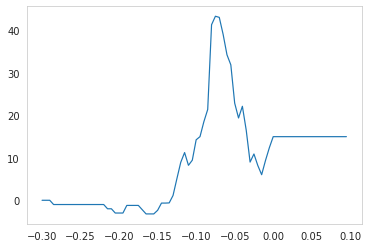

<Figure size 14400x7200 with 0 Axes>

In [55]:
plt.plot(x, y1, '-', lw=1.2, label=f'Train error bn size: {bn_size}')
plt.figure(figsize=(200,100))

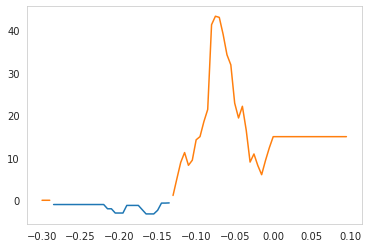

In [56]:
upper = 0

y = np.asarray(y1)
supper = np.ma.masked_where(y < upper, y)
slower = np.ma.masked_where(y >= upper, y)

fig, ax = plt.subplots()
ax.plot(x, slower, x, supper)
plt.show()

In [57]:
print(len(y1))
print(len(slower)+len(supper))

80
160


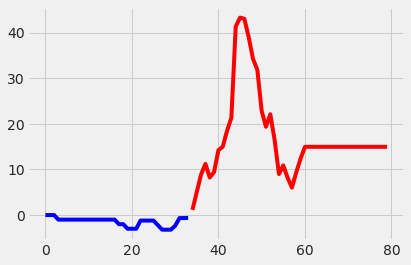

In [58]:
y2 = np.asarray(y1)
pos_signal = y2.copy()
neg_signal = y2.copy()

pos_signal[pos_signal <= 0] = np.nan
neg_signal[neg_signal > 0] = np.nan

#plotting
plt.style.use('fivethirtyeight')
plt.plot(pos_signal, color='r')
plt.plot(neg_signal, color='b')
plt.savefig('pos_neg.png', dpi=200)
plt.show()

In [0]:
final = pd.read_csv(PATH_TO_DATA+'/Generated/Final.csv')
final_ori = final.copy()

In [0]:
data = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')

In [61]:
len(data)

1199

In [62]:
len(final)

1349

In [63]:
final = final[~final.isin(data)].dropna()
print(len(final))

150


In [0]:
final = final.drop(columns=['Unnamed: 0','HomeTeam','AwayTeam']).reset_index(drop=True)

In [0]:
final['B365H'] = 1/final['B365H']
final['B365D'] = 1/final['B365D']
final['B365A'] = 1/final['B365A']
final['Sum'] = final['B365H'] + final['B365D'] + final['B365A'] 
final['B365H'] = final['B365H']/final['Sum']
final['B365D'] = final['B365D']/final['Sum']
final['B365A'] = final['B365A']/final['Sum']
del final['Sum']

In [0]:
finalset = DatasetDF(final.drop(columns='FTR'), final['FTR'], final['Date'])
test_loader = torch.utils.data.DataLoader(
    finalset,
    batch_size=hparams1['batch_size'])

In [67]:
final.head()

,B365H,B365D,B365A,FTR,Date,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,HomeTeam_MedioMean,HomeTeam_MedioMedian,HomeTeam_OverallMax,HomeTeam_OverallMean,HomeTeam_OverallMedian,HomeTeam_PorteroMax,HomeTeam_PorteroMean,HomeTeam_PorteroMedian,HomeTeam_TopOverallMean,HomeTeam_TopOverallMedian,HomeTeam_TopOverallMin,AwayTeamPercPoints,AwayTeamGolsFavorMean,AwayTeamGolsFavorMedian,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0.157464,0.269939,0.572597,D,29/10/2019,0.366667,0.800000,1.0,2.0,1.300000,1.0,4.0,9.0,7.0,6.0,13.0,4.0,10.0,14.0,8.0,3.0,11.0,50.0,1.000000,1.0,2.0,0.0,1.052632,1.0,5.0,1.0,27.636364,29.0,79.0,77.00,77.0,77.0,75.500000,75.5,78.0,75.250000,76.5,82.0,76.545455,77.0,82.0,82.0,82.0,76.545455,77.0,70.0,0.633333,1.0,1.0,3.0,0.5,0.0,2.0,2.0,15.0,7.0,22.0,1.0,5.0,6.0,3.0,7.0,10.0,76.0,1.684211,1.0,3.0,1.0,1.210526,1.0,4.0,1.0,24.909091,26.0,85.0,81.50,82.0,83.0,81.500000,81.5,85.0,83.750000,84.0,91.0,83.181818,83.0,91.0,91.0,91.0,83.181818,83.0,77.0
1,0.844754,0.099592,0.055654,H,29/10/2019,0.703704,2.555556,2.0,5.0,1.111111,1.0,2.0,1.0,15.0,11.0,26.0,1.0,2.0,3.0,3.0,6.0,9.0,87.0,2.684211,2.0,8.0,2.0,2.052632,2.0,5.0,1.0,28.454545,30.0,88.0,85.50,86.0,94.0,90.666667,89.0,89.0,86.666667,86.0,94.0,87.636364,88.0,90.0,90.0,90.0,87.636364,88.0,82.0,0.466667,1.0,1.0,2.0,0.9,1.0,2.0,16.0,5.0,5.0,10.0,9.0,8.0,17.0,5.0,6.0,11.0,41.0,0.842105,1.0,2.0,0.0,0.842105,1.0,3.0,0.0,26.636364,28.0,77.0,75.00,75.0,77.0,76.000000,76.0,79.0,76.000000,75.5,81.0,76.090909,76.0,81.0,81.0,81.0,76.090909,76.0,73.0
2,0.639344,0.213115,0.147541,A,30/10/2019,0.633333,1.700000,1.5,3.0,1.000000,1.0,3.0,11.0,7.0,6.0,13.0,6.0,8.0,14.0,6.0,5.0,11.0,50.0,1.210526,1.0,3.0,0.0,1.157895,1.0,3.0,0.0,25.272727,25.0,77.0,75.25,76.0,82.0,81.000000,82.0,83.0,80.000000,79.0,83.0,78.545455,79.0,80.0,80.0,80.0,78.545455,79.0,72.0,0.366667,1.0,1.0,2.0,1.2,1.0,3.0,15.0,6.0,5.0,11.0,6.0,10.0,16.0,7.0,4.0,11.0,44.0,1.789474,2.0,4.0,2.0,1.315789,1.0,4.0,0.0,27.818182,28.0,78.0,77.00,77.0,82.0,78.000000,77.0,80.0,77.666667,78.0,82.0,77.363636,77.0,76.0,76.0,76.0,77.363636,77.0,75.0
3,0.339728,0.279776,0.380496,D,30/10/2019,0.433333,1.400000,1.0,3.0,1.600000,1.0,5.0,4.0,7.0,8.0,15.0,2.0,5.0,7.0,10.0,6.0,16.0,61.0,1.263158,1.0,3.0,0.0,1.421053,1.0,6.0,1.0,27.818182,28.0,83.0,81.50,81.5,83.0,82.000000,82.0,86.0,82.250000,81.5,86.0,82

In [0]:
def getMin(a, liston=-0.05):
  aux = min(a)
  if (aux > liston):
    return '_'
  for lletra in ['H','D','A']:
    if aux == a[lletra]:
      return lletra

In [69]:
test_iter = iter(test_loader)
tot = 0
apuestas = 0
aciertos = 0
for i in range(len(test_iter)):
  data_res = final.copy()
  inputs, targets, ftr, date = test_iter.next()
  outputs = models[3](inputs.to(device))
  outputs = outputs.detach().cpu().numpy()
  targets = targets.detach().cpu().numpy()

  res = pd.concat([pd.DataFrame(targets,columns=['B365H','B365D','B365A']), pd.DataFrame(outputs,columns=['B365H_Pred','B365D_Pred','B365A_Pred'])],axis=1)
  res['FTR'] = ftr
  res['Date'] = date
  N = 10000
  #thank you koalo for comment
  res.B365H = np.round(res.B365H*N).astype(int) 
  data_res.B365H = np.round(data_res.B365H*N).astype(int) 
  res.B365D = np.round(res.B365D*N).astype(int) 
  data_res.B365D = np.round(data_res.B365D*N).astype(int) 
  res.B365A = np.round(res.B365A*N).astype(int) 
  data_res.B365A = np.round(data_res.B365A*N).astype(int) 

  res = pd.merge(res,data_res,how='left', on=['B365H','B365D','B365A','FTR', 'Date'],)
  res.B365H = res.B365H/N
  res.B365D = res.B365D/N
  res.B365A = res.B365A/N

  res['H'] = res['B365H'] - res['B365H_Pred']
  res['D'] = res['B365D'] - res['B365D_Pred']
  res['A'] = res['B365A'] - res['B365A_Pred']
  a = res[['H','D','A']].copy()
  res['Win'] = a.apply(getMin,axis=1)

  comp = res[['Win','FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax']].copy()
  aux = pd.merge(comp,final_ori,how='left', on=['FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax'])
  #display(final_ori)
  results = aux.apply(getWinning,axis=1)
  #display(res[['B365H','B365H_Pred','B365D','B365D_Pred','B365A','B365A_Pred','H','D','A','Win','FTR']])
  #display(res[['B365H','B365D','B365A','Win','FTR']])
  apuestas += len(res[res['Win']!='_'])
  aciertos += len(res[res['Win']==res['FTR']])
  print(results.sum())
  tot += results.sum() 

2.5
1.9
0.0
0.5
0.010000000000000009
-3
1.5899999999999999
0.0
2.1
-0.73
-2
-1.7000000000000002
2.1999999999999997
-3
0.10000000000000009
-1.38
-2
-0.050000000000000044
-1.4
4.75
1.0
-1
3.0
-0.3500000000000001
0.5
1.7999999999999998
-1.6
-3
-3
3.52


In [70]:
tot

1.259999999999998

In [71]:
apuestas

90

In [72]:
aciertos

36